# https://createwith.ai/7511b4620de94e60b421c172b34acd8c
# Settings

In [1]:
import torchaudio
from pathlib import Path
import itertools
from matplotlib import pyplot as plt
import os

os.environ['CUDA_VISIBLE_DEVICES']='0,2' # personal use

# CONSTANTS
SAMPLE_RATE = 22050

# Possible combinations of extracted tracks. 
TYPES_TRACK = ["drums.wav", "bass.wav", "other.wav"]
COMB_TRACK = list(itertools.combinations(TYPES_TRACK, 2))
print(COMB_TRACK)

[('drums.wav', 'bass.wav'), ('drums.wav', 'other.wav'), ('bass.wav', 'other.wav')]


# Dataset

In [2]:
import torchaudio
import torchvision
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np 
import functools
import random
import torch
from torch.utils.data import DataLoader

class LoopComb(Dataset):
    def __init__(self, path, size):
        dirs = list(Path(path).glob("*"))[:size]

        # positive pairs
        self.positives = [(os.path.join(d, t1), os.path.join(d, t2)) for d in dirs for t1, t2 in COMB_TRACK]
        self.positives = [ (t1, t2) for t1, t2 in self.positives if (os.path.exists(t1) and os.path.exists(t2))]
        print("positives #", len(self.positives))

        # random pairs
#        dirs = Path(path).glob("*")
        dirnames = list(dirs)
        self.negatives = []
        for _ in range(int(len(self.positives)/len(COMB_TRACK))):
            d1, d2 = random.choices(dirnames, k=2)
            self.negatives.extend( [(os.path.join(d1, t1), os.path.join(d2, t2)) for t1, t2 in COMB_TRACK])
        self.negatives = [ (t1, t2) for t1, t2 in self.negatives if (os.path.exists(t1) and os.path.exists(t2))]
        print("negatives #", len(self.negatives))

        self.items = self.positives.copy()
        self.items.extend(self.negatives)

        # labels
        # We expect that the tracks from the same song sould be mapped closer to each other in the embedding space.
        # That's why we assign 0 for positive samples (i.e., sampled from the same song), 1 for negative samples 
        self.labels = [0] * len(self.positives)
        self.labels.extend([1] * len(self.negatives))
        assert len(self.items) == len(self.labels)
        self.labels = torch.FloatTensor(self.labels) # convert labels to float tensor for the backpropagation. 

        self.length = len(self.items)
        print("all samples #", len(self.items))
        self.transforms = torchvision.transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128, normalized=False),
                    torchaudio.transforms.AmplitudeToDB(top_db=80.)])

    @functools.lru_cache(maxsize=50000) # least recently used cache - 一番古く使われたものから消していく
    def __getitem__(self, index):
        (filepath1, filepath2), label = self.items[index], self.labels[index]
        tensor1 = self.convert_to_tensor(filepath1)
        tensor2 = self.convert_to_tensor(filepath2)
        return (tensor1, tensor2), label

    def __len__(self):
        return self.length

    def convert_to_tensor(self,filepath):
        audio_tensor, sr = torchaudio.load(filepath)
        audio_tensor = audio_tensor.mean(axis=0).unsqueeze(0)
        audio_tensor = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(audio_tensor)
        return self.transforms(audio_tensor)

In [3]:
# datasets and dataloaders
train_path = './dataset/youtube-5m-loops-valid/train'
val_path = './dataset/youtube-5m-loops-valid/val'
trainSet = LoopComb(train_path, -1)
valSet = LoopComb(val_path,-1)

trainLoader = DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=4)
valLoader = DataLoader(valSet, batch_size=32, shuffle=True, num_workers=4)

positives # 19785
negatives # 19770
all samples # 39555
positives # 1716
negatives # 1716
all samples # 3432


torch.Size([1, 128, 173]) tensor(1.)
tensor(39.5267) tensor(-40.4733) tensor(-33.5395) tensor(80.)


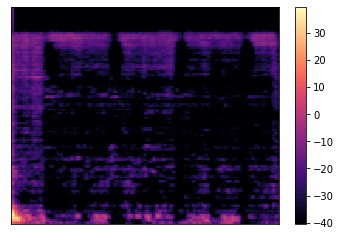

In [4]:
# Sample data
(t1, t2), label = trainSet[random.randint(0, len(trainSet))]
print(t1.shape, label)

from librosa import display
plt.figure()
display.specshow(t1.detach().numpy()[0])
print(t1.max(), t1.min(), t1.mean(), t1.max()-t1.min())
plt.colorbar()

# Model

In [5]:
import  torch
import  torch.nn    as  nn
import  torch.nn.functional as F

# GPU Settings
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda") 
else:
    print("Using CPU")
    device = torch.device("cpu")

class Siamese(nn.Module):


    def __init__(self):
        super(Siamese, self).__init__()
        dropout_rate = 0.1

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3),  # 64@96*96
            nn.ReLU(),
            # nn.Conv2d(32, 32, 3),  # 64@96*96
            # nn.ReLU(),
#            nn.MaxPool2d(4),  # 64@48*48
            nn.Conv2d(16, 4, 3),
            nn.ReLU(),    # 128@42*42
#            nn.MaxPool2d(4),   # 128@21*21
#            nn.Conv2d(32, 4, 4),
#            nn.ReLU(), # 128@18*18
#            nn.MaxPool2d(2), # 128@9*9
#            nn.Conv2d(128, 256, 4),
#            nn.ReLU(),   # 256@6*6
        )
        self.linear = nn.Sequential(nn.Linear(83824, 1024), nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(1024, 256), nn.ReLU())
        self.out = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        x = self.linear2(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        return self.sigmoid(out)
        #return out

Using GPU


In [6]:
# Model Initialization

net = Siamese()
print(net)

loss_fn = torch.nn.BCEWithLogitsLoss(size_average=True)
net.to(device)


Siamese(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=83824, out_features=1024, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (out): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


/home/nao/anaconda3/envs/loopcomb/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Siamese(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=83824, out_features=1024, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (linear2): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (out): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
# model summary
from torchsummary import summary

(t1, t2), label = trainSet[0]
print(t1.shape)
summary(net.cuda(), [(1, 128, 173),(1, 128, 173)])
net.cuda().forward(t1.unsqueeze(0).cuda(), t2.unsqueeze(0).cuda())

torch.Size([1, 128, 173])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 171]             160
              ReLU-2         [-1, 16, 126, 171]               0
            Conv2d-3          [-1, 4, 124, 169]             580
              ReLU-4          [-1, 4, 124, 169]               0
            Linear-5                 [-1, 1024]      85,836,800
           Dropout-6                 [-1, 1024]               0
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
           Dropout-9                  [-1, 256]               0
             ReLU-10                  [-1, 256]               0
           Conv2d-11         [-1, 16, 126, 171]             160
             ReLU-12         [-1, 16, 126, 171]               0
           Conv2d-13          [-1, 4, 124, 169]             580
             

tensor([[0.3360]], device='cuda:0', grad_fn=<SigmoidBackward>)

# Training

In [8]:
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Training loop
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    best_val_loss = 10000.0

    for epoch in range(epochs):
        print("Epoch: ", epoch)
        training_loss = 0.0
        valid_loss = 0.0

        model.train() # 学習モードにセット　DropoutLayerなどが有効に

        for batch in tqdm(train_loader):
            optimizer.zero_grad() # 一旦リセット

            (input1, input2), labels = batch
            input1 = input1.to(device)
            input2 = input2.to(device)

            labels = labels.unsqueeze(1)
            labels = labels.to(device)

            output = model(input1, input2)

            # print(labels.shape, output.shape)
            # print(labels, output)   
            loss = loss_fn(output, labels)
            loss.backward() # back propagation - gradientの計算

            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(train_loader) # average

        model.eval()# 学習モードをオフ　DropoutLayerなどが無効に モデルのパラメータはアップデートされない
        num_correct = 0
        num_examples = 0
        for batch in tqdm(val_loader):

            (input1, input2), labels = batch
            input1 = input1.to(device)
            input2 = input2.to(device)

            labels = labels.unsqueeze(1)
            labels = labels.to(device)

            output = model(input1, input2)

            loss = loss_fn(output, labels)
            valid_loss += loss.data.item()

            correct = torch.eq(output > 0.5, labels).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)

        accuracy = num_correct/num_examples
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Accuracy = {:.2f}'
            .format(epoch, training_loss, valid_loss, accuracy))
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save(net.state_dict(), "./tmp/model_epoch_%d_val_%.4f_acc_%.4f.pt" % (epoch, valid_loss, accuracy))

In [9]:
net.train()

optimizer = torch.optim.Adam(net.parameters(),lr = 0.0001)
optimizer.zero_grad()

train(net, optimizer, loss_fn, trainLoader, valLoader, epochs=100, device=device)


Epoch:  0


100%|██████████| 108/108 [01:41<00:00,  1.06it/s]


Epoch: 0, Training Loss: 0.69, Validation Loss: 0.69, Accuracy = 0.50
Epoch:  1


100%|██████████| 108/108 [01:39<00:00,  1.08it/s]


Epoch: 1, Training Loss: 0.69, Validation Loss: 0.69, Accuracy = 0.50
Epoch:  2


100%|██████████| 108/108 [02:09<00:00,  1.20s/it]


Epoch: 2, Training Loss: 0.69, Validation Loss: 0.69, Accuracy = 0.50
Epoch:  3


 31%|███       | 385/1237 [04:43<10:27,  1.36it/s]


KeyboardInterrupt: 

In [ ]:
from torchsummary import summary

(t1, t2), label = trainSet[0]

print(t1.shape)

summary(net.cuda(), [(1, 128, 173),(1, 128, 173)])

#net.forward(t1, t2)
#print(t1.mean(axis=0).shape)
net.cuda().forward(t1.unsqueeze(0).cuda(), t2.unsqueeze(0).cuda())

torch.Size([1, 128, 173])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 171]             640
              ReLU-2         [-1, 64, 126, 171]               0
            Conv2d-3          [-1, 4, 124, 169]           2,308
              ReLU-4          [-1, 4, 124, 169]               0
            Linear-5                 [-1, 1024]      85,836,800
           Sigmoid-6                 [-1, 1024]               0
            Linear-7                  [-1, 512]         524,800
           Sigmoid-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
          Sigmoid-10                  [-1, 256]               0
           Conv2d-11         [-1, 64, 126, 171]             640
             ReLU-12         [-1, 64, 126, 171]               0
           Conv2d-13          [-1, 4, 124, 169]           2,308
             

tensor([[-0.0040]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
torch.cuda.empty_cache()